In [1]:
import astra
import numpy as np
import itertools
import time
import multiprocessing as mp
import warnings

from multiprocessing import sharedctypes
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import lil_matrix
from dask import array as da
from dask.distributed import Client
from dask import delayed

In [2]:
def MLOS(numViews, p, raysPerProj, A):
    # Initialize the projection to volume list
    projToVol = [None] * numViews

    # Smear each of the cameras individually across the volume
    for i in range(numViews):
        projToVol[i] = (
                        p[i*raysPerProj:(i+1)*raysPerProj]
                        @
                        A[i*raysPerProj:(i+1)*raysPerProj]
                        )

    # Multiply all of the smeared volumes with each other
    vInit = np.prod(np.asarray(projToVol), axis=0)**(1/numViews)

    return vInit


def reduceVoxels(vInit):
    # Convert all of the non-zero voxels to True, rest to False
    vInit_nonzero = vInit > 0
    
    # Get the indices of all the valid voxels
    validVoxels = np.where(vInit_nonzero == True)[0]
    
    return validVoxels

In [3]:
# Load Shepp-Logan phantom
phantom = loadmat('phantom.mat')['phantom256']
size = phantom.shape[0]

# Define number of cameras
numViews = 10

# Create geometries and projector
proj_geom = astra.create_proj_geom('parallel', 1.0, size,
                                   np.linspace(0, 2*np.pi, numViews))
vol_geom = astra.create_vol_geom(size, size)
proj_id = astra.create_projector('linear', proj_geom, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

# Retrieve phantom system matrix as a compressed sparse row array
A = astra.matrix.get(matrix_id)

# create forward projection
[sinogram_id, sinogram] = astra.create_sino(phantom, proj_id)

# Setup the projection matrix as an opTomo object
W = astra.optomo.OpTomo(proj_id)

# Get the squared L2-norm of the projection matrix
normA = np.asarray(A.multiply(A).sum(axis=1)).squeeze()

# Prepare the projections into a ravelled array
p = sinogram.ravel()

# Number of rays per projection
raysPerProj = len(p) // numViews

In [4]:
%%time
# Run MLOS to get an initial volume estimation
vInit = MLOS(numViews, p, raysPerProj, A)

# Get the indices of all the valid voxels using MLOS
validVoxels = reduceVoxels(vInit)

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 18.2 ms


In [5]:
%%time
# Crop down the projection matrix to valid voxels
A = A[:, validVoxels]

# Get all the pixels for each voxel
projRows = [A[:,i].nonzero()[0] for i, _ in enumerate(validVoxels)]

CPU times: user 21.8 s, sys: 15.6 ms, total: 21.8 s
Wall time: 21.8 s


# MART (Subbarao)

## MART2
<div>
    <div>
        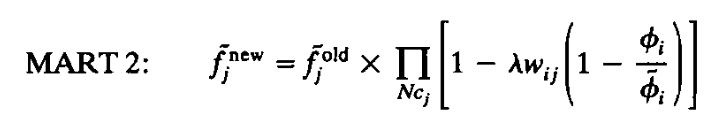
    </div>
    <div>
        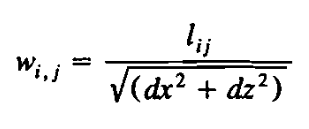
    </div>
</div>

In [6]:
%%time
#x = np.ones_like(vInit[validVoxels])
#x = W.BP(sinogram).ravel()[validVoxels]
x = vInit[validVoxels]
mu = 2
phi = sinogram.ravel()
err_mart2 = []

for iter in range(100):
    err_old = np.sum(x)
    
    # Find the approximate projection
    approx_phi = A * x
    ratio = np.divide(phi, approx_phi, out=np.zeros_like(phi), where=approx_phi!=0)

    # Find the correction factor for each cell j ('voxel')
    # Remember that Subbarao finds the weighting by normalizing it!
    cf = np.array([
                   np.prod(1 - mu * ((A[projRows[j], j].data / normA[projRows[j]]) * (1-ratio[projRows[j]]))) 
                   for j, _ in enumerate(x)
                   ])

    # Apply correction to the volume (represents one iteration)
    x *= cf
    
    err_new = np.sum(x)
    err_mart2.append(100*np.abs(err_new-err_old)/err_new)

vol_subbarao_mart2 = np.zeros_like(vInit)
vol_subbarao_mart2[validVoxels] = x
vol_subbarao_mart2 = vol_subbarao_mart2.reshape(phantom.shape)

CPU times: user 8min 56s, sys: 1 s, total: 8min 57s
Wall time: 8min 57s


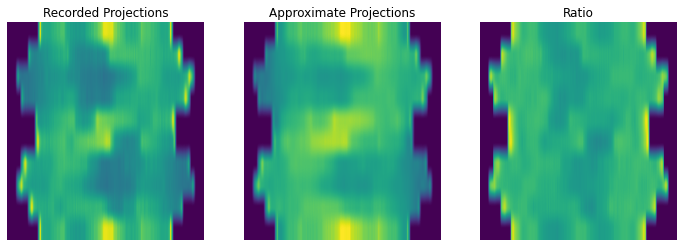

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(phi.reshape(10, 256), aspect='auto')
ax2.imshow(approx_phi.reshape(10, 256), aspect='auto')
ax3.imshow(ratio.reshape(10, 256), aspect='auto')
ax1.set_title('Recorded Projections')
ax2.set_title('Approximate Projections')
ax3.set_title('Ratio')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.show()

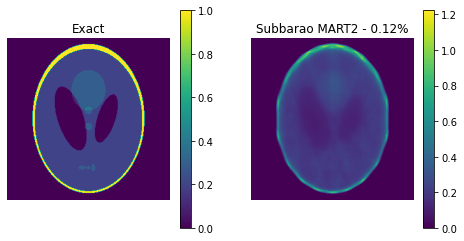

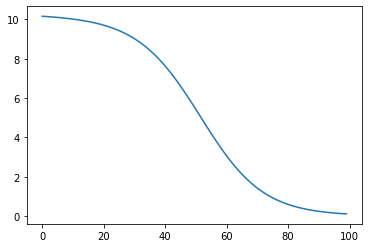

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ph = ax1.imshow(phantom)
re = ax2.imshow(vol_subbarao_mart2)
fig.colorbar(ph, ax=ax1)
fig.colorbar(re, ax=ax2)
ax1.set_title('Exact')
ax2.set_title('Subbarao MART2 - {0:0.2f}%'.format(err_mart2[-1]))
ax1.axis('off')
ax2.axis('off')
fig.show()

plt.figure()
plt.plot(err_mart2)
plt.show()

## MART3
<div>
    <div>
        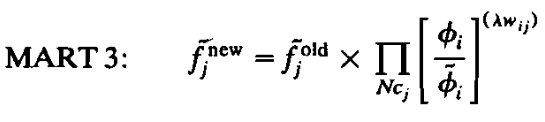
    </div>
</div>

In [9]:
%%time
#x = np.ones_like(vInit[validVoxels])
#x = W.BP(sinogram).ravel()[validVoxels]
x = vInit[validVoxels]
mu = 2
phi = sinogram.ravel()
err_mart3 = []

for iter in range(100):
    err_old = np.sum(x)
    
    # Find the approximate projection
    approx_phi = A * x
    ratio = np.divide(phi, approx_phi, out=np.zeros_like(phi), where=approx_phi!=0)
    
    # Find the correction factor for each cell j ('voxel')
    # Remember that Subbarao finds the weighting by normalizing it!
    cf = np.array([
                   np.prod(ratio[projRows[j]] ** (mu * A[projRows[j], j].data / normA[projRows[j]]))
                   for j, _ in enumerate(x)
                   ])

    # Apply correction to the volume (represents one iteration)
    x *= cf
        
    err_new = np.sum(x)
    err_mart3.append(100*np.abs(err_new-err_old)/err_new)

vol_subbarao_mart3 = np.zeros_like(vInit)
vol_subbarao_mart3[validVoxels] = x
vol_subbarao_mart3 = vol_subbarao_mart3.reshape(phantom.shape)

CPU times: user 8min 47s, sys: 984 ms, total: 8min 48s
Wall time: 8min 48s


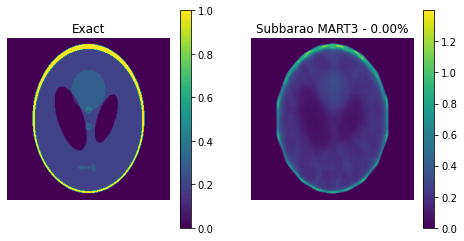

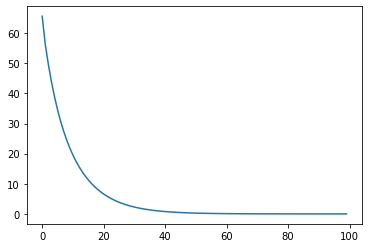

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ph = ax1.imshow(phantom)
re = ax2.imshow(vol_subbarao_mart3)
fig.colorbar(ph, ax=ax1)
fig.colorbar(re, ax=ax2)
ax1.set_title('Exact')
ax2.set_title('Subbarao MART3 - {0:0.2f}%'.format(err_mart3[-1]))
ax1.axis('off')
ax2.axis('off')
fig.show()

plt.figure()
plt.plot(err_mart3)
plt.show()

# SMART (Mishra)

## SMART2
<div>
    <div>
        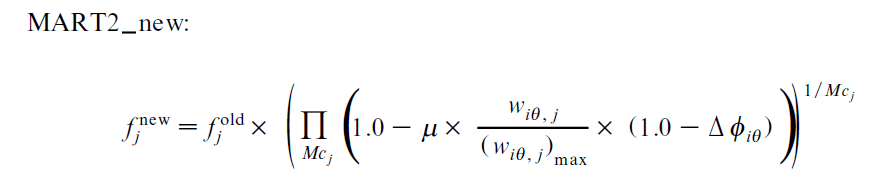
    </div>
</div>

The weight is explicitly normalized here in Mishra's version, as opposed to the implicit version in Subbarao's.

In [11]:
%%time
#x = np.ones_like(vInit[validVoxels])
#x = W.BP(sinogram).ravel()[validVoxels]
x = vInit[validVoxels]
mu = 2
phi = sinogram.ravel()
err_smart2 = []

for iter in range(100):
    err_old = np.sum(x)
    
    # Find the approximate projection
    approx_phi = A * x
    ratio = np.divide(phi, approx_phi, out=np.zeros_like(phi), where=approx_phi!=0)
    
    # Find the correction factor for each cell j ('voxel')
    cf = np.array([
                   np.prod(1 - mu * ((A[projRows[j], j].data / normA[projRows[j]]) * (1-ratio[projRows[j]])))**(1/projRows[j].size) 
                   for j, _ in enumerate(x)
                   ])

    # Apply correction to the volume (represents one iteration)
    x *= cf
    
    err_new = np.sum(x)
    err_smart2.append(100*np.abs(err_new-err_old)/err_new)
    
vol_mishra_smart2 = np.zeros_like(vInit)
vol_mishra_smart2[validVoxels] = x
vol_mishra_smart2 = vol_subbarao_mart2.reshape(phantom.shape)

CPU times: user 9min 16s, sys: 8.11 s, total: 9min 25s
Wall time: 9min 25s


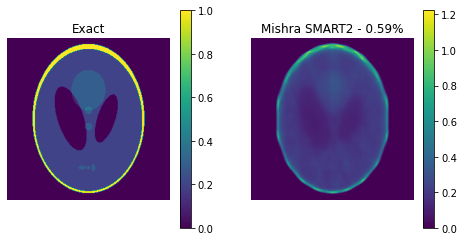

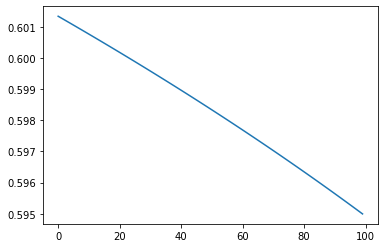

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ph = ax1.imshow(phantom)
re = ax2.imshow(vol_mishra_smart2)
fig.colorbar(ph, ax=ax1)
fig.colorbar(re, ax=ax2)
ax1.set_title('Exact')
ax2.set_title('Mishra SMART2 - {0:0.2f}%'.format(err_smart2[-1]))
ax1.axis('off')
ax2.axis('off')
fig.show()

plt.figure()
plt.plot(err_smart2)
plt.show()

## SMART3
<div>
    <div>
        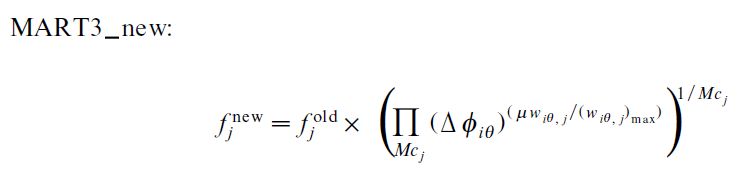
    </div>
</div>

In [13]:
%%time
#x = np.ones_like(vInit[validVoxels])
#x = W.BP(sinogram).ravel()[validVoxels]
x = vInit[validVoxels]
mu = 2
phi = sinogram.ravel()
err_smart3 = []

for iter in range(100):
    err_old = np.sum(x)
    
    # Find the approximate projection
    approx_phi = A * x
    ratio = np.divide(phi, approx_phi, out=np.zeros_like(phi), where=approx_phi!=0)
    
    # Find the correction factor for each cell j ('voxel')
    cf = np.array([
                   np.prod(ratio[projRows[j]] ** (mu * A[projRows[j], j].data / normA[projRows[j]]))**(1/projRows[j].size)
                   for j, _ in enumerate(x)
                   ])

    # Apply correction to the volume (represents one iteration)
    x *= cf
    
    err_new = np.sum(x)
    err_smart3.append(100*np.abs(err_new-err_old)/err_new)

vol_mishra_smart3 = np.zeros_like(vInit)
vol_mishra_smart3[validVoxels] = x
vol_mishra_smart3 = vol_mishra_smart3.reshape(phantom.shape)

CPU times: user 8min 58s, sys: 984 ms, total: 8min 59s
Wall time: 8min 59s


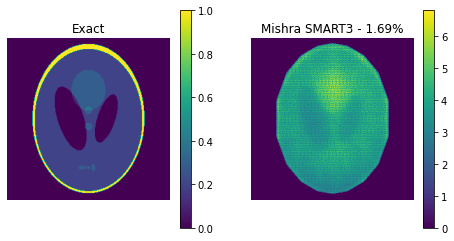

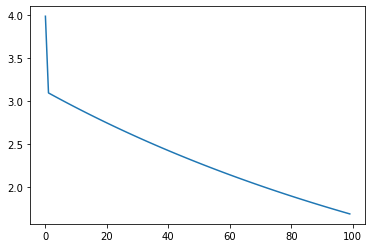

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ph = ax1.imshow(phantom)
re = ax2.imshow(vol_mishra_smart3)
fig.colorbar(ph, ax=ax1)
fig.colorbar(re, ax=ax2)
ax1.set_title('Exact')
ax2.set_title('Mishra SMART3 - {0:0.2f}%'.format(err_smart3[-1]))
ax1.axis('off')
ax2.axis('off')
fig.show()

plt.figure()
plt.plot(err_smart3)
plt.show()

# SMART w/ Dask

In [15]:
client = Client(processes=False)
client

Client Scheduler: inproc://128.46.118.107/11149/1 Dashboard: http://128.46.118.107:8787/status,Cluster Workers: 1 Cores: 8 Memory: 17.06 GB


## SMART2

In [ ]:
%%time
#x = np.ones_like(vInit[validVoxels])
#x = W.BP(sinogram).ravel()[validVoxels]
x = da.from_array(vInit[validVoxels], chunks=len(validVoxels)/4)
mu = 2
phi = sinogram.ravel()
err_smart2 = []

for iter in range(10):
    err_old = da.sum(x)
    
    # Find approximate projections
    approx_phi = da.multiply(A, x)
    ratio = np.divide(phi, approx_phi, out=np.zeros_like(phi), where=approx_phi!=0)
    
    # Find the correction factor for each cell j ('voxel')
    cf = np.array([
                   da.prod(1 - mu * ((A[projRows[j], j].data / normA[projRows[j]]) * (1-ratio[projRows[j]])))**(1/projRows[j].size) 
                   for j, _ in enumerate(x)
                   ])

    # Apply correction to the volume (represents one iteration)
    x *= cf
    
    err_new = da.sum(x)
    err_smart2.append(100*np.abs(err_new-err_old)/err_new)
    
#vol_mishra_smart2 = np.zeros_like(vInit)
#vol_mishra_smart2[validVoxels] = x
#vol_mishra_smart2 = vol_subbarao_mart2.reshape(phantom.shape)